In [ ]:
# %%
import numexpr
# numexpr.set_num_threads(min(8, numexpr.detect_number_of_cores()))
numexpr.set_num_threads(64)

import time
time0 = time.time()
import glob
import pandas as pd
import h5py

import numpy as np
import matplotlib.pyplot as plt
import haccytrees.mergertrees
import pygio
import os

os.environ["CUDA_32VISIBLE_DEVICES"] = ""

import simulation_models
import cosmology_utils
import cores_analysis
import plot_utils
import lightcone_tree_matching
import bpl_analysis
import painting
import catalog_io
import yaml_read
import photometry
import scipy.spatial


%matplotlib inline


# from mpi4py import MPI
import numpy as np
from numba import config
config.THREADING_LAYER = 'workqueue'

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)

In [ ]:
# Find all files matching the target <y> value in the directory

def all_subfiles_in_skypatch(target_skypatch_id):
    single_skypatch_all_subfiles = glob.glob(os.path.join(dirIn_lcXcore, f"lc_cores-*.{str(target_skypatch_id)}.hdf5"))
    return single_skypatch_all_subfiles

# Function to read and extract data from an HDF5 file
def extract_data_single_subfile(file_path):
    with h5py.File(file_path, 'r') as hdf:
        data = {key: hdf[key][:] for key in hdf.keys()}
    return pd.DataFrame(data)

###########################################

In [ ]:
config = yaml_read.yaml_config('config_LJ.yml')

In [ ]:
##########################################


# %%
save_file = config['catalog']['save_dir'] + config['catalog']['catalog_name'] + '_core_' + str(config['hacc_simulation']['coreforestID']) + '_every_' + str(config['painting_model']['plot_frequency']) + '.hdf5'

print(10*'=--=')
print(save_file)
print(10*'=--=')

# %%
dirIn_lcXcore = '/lcrc/project/cosmo_ai/mbuehlmann/LastJourney/core-lc/output/'
dirIn_core = '/lcrc/group/cosmodata/simulations/LastJourney/coretrees/forest/'
target_skypatch_id = config['hacc_simulation']['skypatchID']

print('Skypatch: ', target_skypatch_id)
###########################################

=--==--==--==--==--==--==--==--==--==--=
/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/HACCnPaint/SyntheticCatalog/SuperMock_v10_limited_sampling_core_19_every_500.hdf5
=--==--==--==--==--==--==--==--==--==--=
Skypatch:  129


In [ ]:

cosmo = simulation_models.get_cosmo(config['hacc_simulation']['name'])

# Cosmic Age of all snapshots
sim = haccytrees.Simulation.simulations[config['hacc_simulation']['name']]
print(f"{sim.particle_mass:.3e}")
redshift_steps = sim.step2z(np.array(sim.cosmotools_steps)) # same as redshifts, chronological
cosmic_time = cosmo.age(redshift_steps)

alphaq_analysis_steps = simulation_models.get_analysis_steps(config['hacc_simulation']['name'])
alphaq_analysis_scale = cosmology_utils.a(alphaq_analysis_steps)
alphaq_analysis_redshift = cosmology_utils.redshift(alphaq_analysis_scale)
alphaq_analysis_age = cosmo.age(alphaq_analysis_redshift)

V_bpl = config['reference_simulation']['side_length']**3
V_alphaq = config['hacc_simulation']['side_length']**3

2.717e+09


In [ ]:
V_alphaq

126884390625

In [ ]:
config['hacc_simulation']['side_length']

5025

In [ ]:
# data_a06 = bpl_analysis.load_bpl_data(config['reference_simulation']['sim_dir'], '0.664300', "Non-centrals")

### LC-core matchfiles new -- from Michael
* some cores were missing: eg missing 932 out of 4895923 , I just discared those
* some replications of the same fof halo had a different tag? (just the negative number of the original, not sure why...) I replaced them with the same tag
* some cores within the same halo had a delta_x of several Gpc?! (like 1 out of 100M) I just discarded those
* there are 192 files per step, corresponding to 192 equal area sky patches

* each HDF5 file has arrays storing core information: core_tag, position (xyz), angular coordinates (theta, phi), a file_idx corresponding to the coreforest file that contains the history, and a row_idx corresponding to the row in that corematrix

* I'll move the existing ones to /lcrc/group/cosmodata/simulations/LastJourney/halo_lightcone_LJ/output_old and Globus transfer the new ones from ALCF

### LightconeXCore matched from Michael. 

In [ ]:
###########################################
# Process all matching files
single_skypatch_all_subfiles = all_subfiles_in_skypatch(target_skypatch_id)
single_skypatch_all_data = pd.concat([extract_data_single_subfile(file) for file in single_skypatch_all_subfiles], ignore_index=True)

# subfile_idx = 5
# print(single_skypatch_all_subfiles[subfile_idx])
# print(np.unique(extract_data_single_subfile(single_skypatch_all_subfiles[subfile_idx])["file_idx"]))
# ra_skypatch, dec_skypatch = cosmology_utils.ra_dec(single_skypatch_all_data['x'], single_skypatch_all_data['y'], single_skypatch_all_data['z'])

###########################################

In [ ]:
single_skypatch_all_data

,central,core_tag,file_idx,fof_halo_tag,host_core,infall_fof_halo_center_x,infall_fof_halo_center_y,infall_fof_halo_center_z,merged,phi,row_idx,scale_factor,snapnum,theta,x,y,z
0,1,216304770753757203,74,591323795212,216304770753757203,1618.293701,47.565887,2514.373291,0,5.696105,5607466,0.105265,7,1.712144,-5181.693359,3447.563232,-885.627930
1,1,207301965250560029,74,617565856391,207301965250560029,1689.847656,38.187618,2147.035156,0,5.690938,6869019,0.105339,7,1.771490,-5110.141113,3438.178711,-1252.962402
2,1,225316359465074724,74,613865533810,225316359465074724,1679.999634,9.098755,2059.453125,0,5.695758,6737592,0.104724,7,1.785378,-5119.987305,3409.073975,-1340.549072
3,1,216309306239221781,74,615487527819,216309306239221781,1684.233521,112.550140,2392.674072,0,5.681502,6733706,0.105248,7,1.731719,-5115.760254,3512.532471,-1007.322327
4,1,198294765995819017,98,620455983326,198294765995819017,1699.164795,37.859451,2174.049072,0,5.690137,3005,0.106131,7,1.767521,-5100.834961,3437.857422,-1225.947876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36215696,1,306495828384547384,169,1109475831728,306495828384547384,3036.251465,289.319611,1270.991211,0,5.507776,1059833,0.144754,20,1.954712,-3763.761230,3689.311523,-2129.026123
36215697,1,292980704470369250,169,1095720454400,292980704470369250,2996.675537,336.499115,1376.916260,0,5.506640,417991,0.143451,20,1.933465,-3803.274170,3736.525391,-2023.110474
36215698,1,292980631455924461,169,1101036253602,292980631455924461,3013.034912,278.104370,1265.574951,0,5.512370,651512,0.144032,20,1.955005,-3786.998779,3678.130371,-2134.387939
36215699,1,315498706902190342,169,1091328499315,315498706902190342,2987.495605,367.653198,1493.385010,0,5.503706,214484,0.144404,20,1.912547,-3812.519531,3767.656982,-1906.625610


### Read cores by LC file_idx 

In [ ]:
from haccytrees.coretrees.coretree_reader import corematrix_reader
SIMULATION = haccytrees.Simulation.simulations["LastJourney"]

In [ ]:
# def process_core_file(unique_core_idx, single_skypatch_all_data, dirIn_core, SIMULATION, alphaq_analysis_age, V_alphaq):
#     print(f"Processing core subvolume: {unique_core_idx}")

#     # Generate the core forest file name and load matrices
#     core_forest_file_name = f"{dirIn_core}m000p.coreforest.{unique_core_idx}.hdf5"
#     forest_matrices = corematrix_reader(core_forest_file_name, SIMULATION)

#     # Selection criteria and indices
#     file_idx_selection_criteria = single_skypatch_all_data["file_idx"] == unique_core_idx
#     row_indx_selected_by_file_idx = single_skypatch_all_data[file_idx_selection_criteria]["row_idx"]
#     col_indx_selected_by_file_idx = single_skypatch_all_data[file_idx_selection_criteria]['snapnum']

#     # Batch index all relevant arrays
#     match_data = {key: forest_matrices[key][row_indx_selected_by_file_idx, col_indx_selected_by_file_idx] for key in 
#                   ['vx', 'vy', 'vz', 'fof_halo_tag', 'central', 'merged', 'core_state']}

#     match_x = single_skypatch_all_data[file_idx_selection_criteria]["x"]
#     match_y = single_skypatch_all_data[file_idx_selection_criteria]["y"]
#     match_z = single_skypatch_all_data[file_idx_selection_criteria]["z"]

#     match_data.update({
#         'x': match_x,
#         'y': match_y,
#         'z': match_z
#     })

#     # Host properties computation
#     mask = forest_matrices['top_host_row'] > 1
#     _full_idx = (forest_matrices['top_host_row'][mask], forest_matrices['snapnum'][mask])
#     parent_fof_mass = np.empty_like(forest_matrices['infall_fof_halo_mass'])
#     parent_fof_mass[:] = -1
#     parent_fof_mass[mask] = forest_matrices['infall_fof_halo_mass'][_full_idx]
#     match_fof_halo_mass_row = parent_fof_mass[row_indx_selected_by_file_idx, :]

    
#     ##########################################################
    
#     # Analysis computations
#     # match_state = match_data['core_state']
#     match_state_row = forest_matrices['core_state'][row_indx_selected_by_file_idx, :]

#     time_infall = cores_analysis.infall_time_alphaq(match_state_row, alphaq_analysis_age)
#     t50_a1 = cores_analysis.mass_time_alphaq(match_fof_halo_mass_row, alphaq_analysis_age, 0.5)
#     t25_a1 = cores_analysis.mass_time_alphaq(match_fof_halo_mass_row, alphaq_analysis_age, 0.25)
#     peak_mass = cores_analysis.peak_mass_HACC(match_fof_halo_mass_row)
#     rank_peak_mass = cores_analysis.mass_rank_alphaq(match_fof_halo_mass_row, V_alphaq)

#     # Add new data to match_data
#     match_data.update({
#         # 'match_fof_halo_mass': match_fof_halo_mass,
#         'time_infall': time_infall,
#         't50_a1': t50_a1,
#         't25_a1': t25_a1,
#         'peak_mass': peak_mass,
#         'rank_peak_mass': rank_peak_mass
#     })
    
#     ##########################################################
    
    
#     match_xyz = np.array([match_x, match_y, match_z]).T
#     match_vel_xyz = np.array([match_data["vx"], match_data["vy"], match_data["vz"]]).T
    
#     match_redshift = cosmology_utils.redshift_from_xyz(match_xyz)
    
#     z_pec, z_tot, _, _, _, _, _ = cosmology_utils.pecZ(match_xyz[:, 0],  
#                                    match_xyz[:, 1], 
#                                    match_xyz[:, 2], 
#                                    match_vel_xyz[:, 0], 
#                                    match_vel_xyz[:, 1], 
#                                    match_vel_xyz[:, 2], 
#                                    match_redshift, 
#                                    obs=np.zeros(3))


#     ra_match, dec_match = cosmology_utils.ra_dec(match_x, match_y, match_z)

    
#     match_data.update({
#         # 'match_fof_halo_mass': match_fof_halo_mass,
#         'ra': ra_match,
#         'dec': dec_match,
#         'redshift': z_tot,
#     })    

#     return match_data


# ###########################################


def process_core_file(unique_core_idx, single_skypatch_all_data, dirIn_core, SIMULATION, alphaq_analysis_age, V_alphaq, config):
    print(f"Processing core subvolume: {unique_core_idx}")

    # Step 1: Define utility functions
    def initialize_cosmology(config):
        smdpl_cosmo = simulation_models.get_cosmo(config['reference_simulation']['name'])
        redshift = np.array([0.5, 0.25, 0.0])
        cosmic_time = smdpl_cosmo.age(redshift)
        t0 = cosmic_time[-1]
        print(f"Age of the universe: {t0} Gyrs")
        return smdpl_cosmo, cosmic_time

    def get_bpl_times_scale(config):
        return bpl_analysis.bpl_times_scale(config['reference_simulation']['sim_dir'])

    def prepare_time_array(scale_bpl, time_bpl, target_scale):
        time_idx = np.where(scale_bpl == target_scale)[0][0]
        return time_bpl[:time_idx + 1]

    def load_and_process_data(sim_dir, scale, galaxy_type, smdpl_cosmo, time_arr, V_bpl):
        data = bpl_analysis.load_bpl_data(sim_dir, f'{scale:.6f}', galaxy_type)
        sorted_mpeak = bpl_analysis.peak_mass_smdpl(data)
        infall_time = bpl_analysis.infall_time_smdpl(smdpl_cosmo, data)
        rank_sorted_mpeak = bpl_analysis.mass_rank_smdpl(data, V_bpl)
        t50 = bpl_analysis.mass_time_smdpl(time_arr, data, 0.5)
        t25 = bpl_analysis.mass_time_smdpl(time_arr, data, 0.25)
        # bpl_sfh = data["sfr_history_all_prog"]
        bpl_sfh = np.pad(data["sfr_history_all_prog"], ((0, 0), (0, 117 - data["sfr_history_all_prog"].shape[1])), mode='constant')
        bpl_sm = data["sm"]
        return {
            "mass_times": np.array([t50, t25, sorted_mpeak, infall_time]).T,
            "sfh": bpl_sfh,
            "sm": bpl_sm
        }

    def kdtree_match(bpl_summary, lc_summary, bpl_sfh, bpl_sm):
        from scipy.spatial import KDTree
        bpl_tree = KDTree(bpl_summary)
        distance, bpl_index = bpl_tree.query(lc_summary, k=1)
        bpl_match_sfh = bpl_sfh[bpl_index]
        bpl_match_sm = bpl_sm[bpl_index]
        return bpl_match_sfh, bpl_match_sm

    # Step 2: Initialize cosmology and BPL data
    smdpl_cosmo, cosmic_time = initialize_cosmology(config)
    time_bpl, scale_bpl = get_bpl_times_scale(config)

    time_arr_a1 = prepare_time_array(scale_bpl, time_bpl, 1.0)
    time_arr_a06 = prepare_time_array(scale_bpl, time_bpl, 0.664300)

    centrals_data = load_and_process_data(config['reference_simulation']['sim_dir'], 1.0, "Centrals", smdpl_cosmo, time_arr_a1, V_alphaq)
    noncentrals_a1_data = load_and_process_data(config['reference_simulation']['sim_dir'], 1.0, "Non-centrals", smdpl_cosmo, time_arr_a1, V_alphaq)
    noncentrals_a06_data = load_and_process_data(config['reference_simulation']['sim_dir'], 0.664300, "Non-centrals", smdpl_cosmo, time_arr_a06, V_alphaq)

    # Step 3: Load core forest data
    core_forest_file_name = f"{dirIn_core}m000p.coreforest.{unique_core_idx}.hdf5"
    forest_matrices = corematrix_reader(core_forest_file_name, SIMULATION)

    file_idx_selection_criteria = single_skypatch_all_data["file_idx"] == unique_core_idx
    row_indx_selected_by_file_idx = single_skypatch_all_data[file_idx_selection_criteria]["row_idx"]
    col_indx_selected_by_file_idx = single_skypatch_all_data[file_idx_selection_criteria]['snapnum']

    match_data = {key: forest_matrices[key][row_indx_selected_by_file_idx, col_indx_selected_by_file_idx] for key in 
                  ['vx', 'vy', 'vz', 'fof_halo_tag', 'central', 'merged', 'core_state']}
    match_data.update({
        'core_tag': single_skypatch_all_data[file_idx_selection_criteria]["core_tag"],
        'x': single_skypatch_all_data[file_idx_selection_criteria]["x"],
        'y': single_skypatch_all_data[file_idx_selection_criteria]["y"],
        'z': single_skypatch_all_data[file_idx_selection_criteria]["z"]
    })
    
    # Step 6: Add spatial and velocity data
    match_xyz = np.array([match_data['x'], match_data['y'], match_data['z']]).T
    match_vel_xyz = np.array([match_data["vx"], match_data["vy"], match_data["vz"]]).T
    
    # match_redshift = cosmology_utils.redshift_from_xyz(match_xyz)
    match_redshift = np.array([1/single_skypatch_all_data[file_idx_selection_criteria]["scale_factor"] ][0]) - 1
    
    z_pec, z_tot, _, _, _, _, _ = cosmology_utils.pecZ(match_xyz[:, 0], match_xyz[:, 1], match_xyz[:, 2],
                                                       match_vel_xyz[:, 0], match_vel_xyz[:, 1], match_vel_xyz[:, 2],
                                                       match_redshift, obs=np.zeros(3))
    
    ra_match, dec_match = cosmology_utils.ra_dec(match_data['x'], match_data['y'], match_data['z'])

    match_data.update({
        'ra': ra_match,
        'dec': dec_match,
        'redshift': z_tot
    })

    # Step 4: Compute host properties and analysis metrics
    mask = forest_matrices['top_host_row'] > 1
    _full_idx = (forest_matrices['top_host_row'][mask], forest_matrices['snapnum'][mask])
    parent_fof_mass = np.empty_like(forest_matrices['infall_fof_halo_mass'])    ###### CAREFUL HERE -- Check with Patricia
    parent_fof_mass[:] = -1
    parent_fof_mass[mask] = forest_matrices['infall_fof_halo_mass'][_full_idx] 
    # infall_tree_node_mass ----- use this and see. Otherwise there might be too many massive objects?
    match_fof_halo_mass_row = parent_fof_mass[row_indx_selected_by_file_idx, :]
    #### Check fragment issue, tree-node-mass is probably better -- Check. 
    #### 

    match_state_row = forest_matrices['core_state'][row_indx_selected_by_file_idx, :]
    time_infall = cores_analysis.infall_time_alphaq(match_state_row, alphaq_analysis_age)
    t50_a1 = cores_analysis.mass_time_alphaq(match_fof_halo_mass_row, alphaq_analysis_age, 0.5)
    t25_a1 = cores_analysis.mass_time_alphaq(match_fof_halo_mass_row, alphaq_analysis_age, 0.25)
    peak_mass = cores_analysis.peak_mass_HACC(match_fof_halo_mass_row)
    rank_peak_mass = cores_analysis.mass_rank_alphaq(match_fof_halo_mass_row, V_alphaq)

    match_data.update({
        'time_infall': time_infall,
        't50_a1': t50_a1,
        't25_a1': t25_a1,
        'peak_mass': peak_mass,
        'rank_peak_mass': rank_peak_mass
    })

    # Step 5: Perform HACC-BPL Cross-matching
    central_cond = (match_data['central'] == 1)
    satellite_cond = (match_data['central'] == 0) & (match_data['merged'] == 0)
    merged_cond = (match_data['central'] == 0) & (match_data['merged'] == 1)

    match_mass_time = np.array([match_data['central'], match_data['merged'], t50_a1, t25_a1, peak_mass, time_infall]).T

    central_indices = np.where(central_cond)[0]
    satellite_indices = np.where(satellite_cond)[0]
    merged_indices = np.where(merged_cond)[0]

    match_mass_time_central = match_mass_time[central_indices, 2:]
    match_mass_time_satellite = match_mass_time[satellite_indices, 2:]

    a_merged_infall = 1 / (1 + match_data['redshift'][merged_cond])
    # a_merged_infall = 1 / (1 + match_redshift[merged_cond])

    merged_high_a_indices = merged_indices[a_merged_infall > 0.664300]
    merged_low_a_indices = merged_indices[a_merged_infall <= 0.664300]

    match_mass_time_merged_high_a = match_mass_time[merged_high_a_indices, 2:]
    match_mass_time_merged_low_a = match_mass_time[merged_low_a_indices, 2:]

    match_sfh_central, match_sm_central = kdtree_match(centrals_data["mass_times"], match_mass_time_central, centrals_data["sfh"], centrals_data["sm"])
    match_sfh_satellite, match_sm_satellite = kdtree_match(noncentrals_a1_data["mass_times"], match_mass_time_satellite, noncentrals_a1_data["sfh"], noncentrals_a1_data["sm"])
    match_sfh_merged_high_a, match_sm_merged_high_a = kdtree_match(noncentrals_a1_data["mass_times"], match_mass_time_merged_high_a, noncentrals_a1_data["sfh"], noncentrals_a1_data["sm"])
    match_sfh_merged_low_a, match_sm_merged_low_a = kdtree_match(noncentrals_a06_data["mass_times"], match_mass_time_merged_low_a, noncentrals_a06_data["sfh"], noncentrals_a06_data["sm"])

    num_galaxies = len(match_mass_time)
    sfh_full = np.zeros((num_galaxies, 117))
    stellar_mass_full = np.zeros(num_galaxies)

    sfh_full[central_indices] = match_sfh_central
    stellar_mass_full[central_indices] = match_sm_central
    sfh_full[satellite_indices] = match_sfh_satellite
    stellar_mass_full[satellite_indices] = match_sm_satellite
    sfh_full[merged_high_a_indices] = match_sfh_merged_high_a
    stellar_mass_full[merged_high_a_indices] = match_sm_merged_high_a
    sfh_full[merged_low_a_indices] = match_sfh_merged_low_a
    stellar_mass_full[merged_low_a_indices] = match_sm_merged_low_a

    match_data.update({
        'sfh': sfh_full,
        'stellar_mass': stellar_mass_full
    })
    
    # print('Number of galaxy matches in this core: ', num_galaxies)
    print('Processed core: ', unique_core_idx, ' with Number of galaxy matches: ', num_galaxies)

    return match_data

##################################


import h5py
from multiprocessing import Pool

# Function to process a batch of indices
def process_batch(args):
    batch_indices, single_skypatch_all_data, dirIn_core, SIMULATION, alphaq_analysis_age, V_alphaq, config, output_file = args
    results = []
    for unique_core_idx in batch_indices:
        match_data = process_core_file(unique_core_idx, single_skypatch_all_data, dirIn_core, SIMULATION, alphaq_analysis_age, V_alphaq, config)
        results.append((unique_core_idx, match_data))
    # Save results of the batch to the output file
    with h5py.File(output_file, "a") as f:
        for unique_core_idx, match_data in results:
            grp = f.create_group(f"core_{unique_core_idx}")
            for key, value in match_data.items():
                grp.create_dataset(key, data=value)
    return len(batch_indices)  # Return the number of processed cores for logging

###########################################

In [ ]:
unique_core_idx = 181
core_forest_file_name = f"{dirIn_core}m000p.coreforest.{unique_core_idx}.hdf5"
forest_matrices = corematrix_reader(core_forest_file_name, SIMULATION)

/home/nramachandra/anaconda3/envs/env_jax_2024/lib/python3.9/site-packages/haccytrees/coretrees/coretree_reader.py:116: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(filename) as forest_file:


In [ ]:
forest_matrices.keys()

dict_keys(['central', 'core_tag', 'fof_halo_tag', 'host_core', 'infall_fof_halo_center_x', 'infall_fof_halo_center_y', 'infall_fof_halo_center_z', 'infall_fof_halo_com_vx', 'infall_fof_halo_com_vy', 'infall_fof_halo_com_vz', 'infall_fof_halo_mass', 'infall_fof_halo_tag', 'infall_step', 'infall_tree_node_index', 'infall_tree_node_mass', 'merged', 'radius', 'snapnum', 'tree_node_index', 'vel_disp', 'vx', 'vy', 'vz', 'x', 'y', 'z', 'host_row', 'top_host_row', 'core_state'])

In [ ]:
unique_core_idx = 181
file_idx_selection_criteria = single_skypatch_all_data["file_idx"] == unique_core_idx

row_indx_selected_by_file_idx = single_skypatch_all_data[file_idx_selection_criteria]["row_idx"]
col_indx_selected_by_file_idx = single_skypatch_all_data[file_idx_selection_criteria]['snapnum']

match_redshift = np.array([1/single_skypatch_all_data[file_idx_selection_criteria]["scale_factor"] ][0]) - 1
print(match_redshift.shape)

(5050,)


In [ ]:
print(single_skypatch_all_data[file_idx_selection_criteria]["core_tag"].shape)
print(forest_matrices['core_tag'][row_indx_selected_by_file_idx, col_indx_selected_by_file_idx].shape)

(5050,)
(5050,)


In [ ]:
single_skypatch_all_data[file_idx_selection_criteria]["core_tag"]

1465360     482134298296587924
1465369     428086773441103335
1465374     437093903976371752
1465380     342518380521062999
1465382     378547108820552619
                   ...        
32308989    482156361543587635
32308994    509177959307805708
32309170    509173492541817382
32309553    536195090306044962
32310754    428113166015139738
Name: core_tag, Length: 5050, dtype: int64

In [ ]:
forest_matrices['core_tag'][row_indx_selected_by_file_idx, col_indx_selected_by_file_idx]

array([482134298296587924, 428086773441103335, 437093903976371752, ...,
       509173492541817382, 536195090306044962, 428113166015139738])

In [ ]:
np.array([np.unique(single_skypatch_all_data["file_idx"],  return_counts=True)[0][np.argsort(-np.unique(single_skypatch_all_data["file_idx"], return_counts=True)[1])],np.unique(single_skypatch_all_data["file_idx"],  return_counts=True)[1][np.argsort(-np.unique(single_skypatch_all_data["file_idx"], return_counts=True)[1])]]).T

array([[     83, 3001535],
       [    107, 2099146],
       [    127, 2002508],
       [     63, 1924930],
       [     38, 1822994],
       [     62, 1596937],
       [     18, 1589289],
       [     39, 1587648],
       [     59, 1551379],
       [     42, 1522025],
       [    103, 1488011],
       [     14, 1360303],
       [    186, 1118007],
       [     87,  962789],
       [     43,  952220],
       [     15,  860712],
       [     58,  789220],
       [     19,  780464],
       [     22,  698061],
       [    190,  638986],
       [     82,  631042],
       [    162,  534308],
       [    147,  526697],
       [    182,  478607],
       [    187,  473849],
       [     86,  415091],
       [     35,  361908],
       [    151,  330900],
       [     34,  318209],
       [     79,  310932],
       [    166,  308365],
       [     66,  307868],
       [     23,  280213],
       [     67,  271710],
       [    191,  243071],
       [    183,  223045],
       [    163,  203183],
 

In [ ]:
file_idx_iters = np.unique(single_skypatch_all_data["file_idx"], 
                               return_counts=True)[0][np.argsort(-np.unique(single_skypatch_all_data["file_idx"], 
                                                                            return_counts=True)[1])]
file_idx_iters[-8:]

array([ 74,  75,   2, 101,   3,  73,  70,   1], dtype=uint16)

In [ ]:
time1 = time.time()
###########################################
if __name__ == "__main__":
    # Prepare inputs
    file_idx_iters = np.unique(single_skypatch_all_data["file_idx"], 
                               return_counts=True)[0][np.argsort(-np.unique(single_skypatch_all_data["file_idx"], 
                                                                            return_counts=True)[1])]  
    # file_idx_iters = file_idx_iters[-8:][::-1]
    # file_idx_iters = file_idx_iters[:2]
    
    file_idx_iters = [17, 181]
    
    
    output_file = "../PaintCores_lcx/tmp_outs/matches_for_lc_skypatch" + str(target_skypatch_id) + ".h5"  # Output file for storing results
    batch_size = 1024  # Define a batch size
    batches = [file_idx_iters[i:i + batch_size] for i in range(0, len(file_idx_iters), batch_size)]

    # Ensure the output file is initialized
    with h5py.File(output_file, "w") as f:
        f.attrs["description"] = "Processed core subvolume matches"

    # Multiprocessing to process batches
    with Pool(processes=48) as pool:  # Adjust 'processes' as needed
        args_list = [(batch, single_skypatch_all_data, dirIn_core, SIMULATION, alphaq_analysis_age, V_alphaq, config, output_file)
                     for batch in batches]
        for processed_count in pool.imap(process_batch, args_list):
            print(f"Processed {processed_count} cores in this batch.")
            
###########################################
          
delta_time = (time.time() - time1)/3600
print('Time: %.2f hr'%delta_time)

Processing core subvolume: 17
Age of the universe: 13.813706418958075 Gyrs
Total runtime = 1.34 seconds
Total runtime = 1.06 seconds
Total runtime = 1.02 seconds


/home/nramachandra/anaconda3/envs/env_jax_2024/lib/python3.9/site-packages/haccytrees/coretrees/coretree_reader.py:116: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(filename) as forest_file:


Processed core:  17  with Number of galaxy matches:  7954
Processing core subvolume: 181
Age of the universe: 13.813706418958075 Gyrs
Total runtime = 1.06 seconds
Total runtime = 1.05 seconds
Total runtime = 0.70 seconds
Processed core:  181  with Number of galaxy matches:  5050
Processed 2 cores in this batch.
Time: 0.20 hr


In [ ]:
def load_matches_from_h5(output_file):
    combined_data = {}
    with h5py.File(output_file, "r") as f:
        for core_key in f.keys():
            for key in f[core_key].keys():
                if key not in combined_data:
                    combined_data[key] = []
                combined_data[key].append(f[core_key][key][...])
    # Concatenate lists of arrays into single arrays for each key
    for key in combined_data:
        combined_data[key] = np.concatenate(combined_data[key], axis=0)
    return combined_data

# Load matches_for_lc from the HDF5 file
matches_for_lc = load_matches_from_h5("../PaintCores_lcx/tmp_outs/matches_for_lc_skypatch" + str(target_skypatch_id) + ".h5")

print('Available match keys: ', matches_for_lc.keys())
print('Matches: ', matches_for_lc['x'].shape, 'Skypatch: ', target_skypatch_id)

Available match keys:  dict_keys(['central', 'core_state', 'dec', 'fof_halo_tag', 'merged', 'peak_mass', 'ra', 'rank_peak_mass', 'redshift', 'sfh', 'stellar_mass', 't25_a1', 't50_a1', 'time_infall', 'vx', 'vy', 'vz', 'x', 'y', 'z'])
Matches:  (13004,) Skypatch:  129


In [ ]:
np.where( (matches_for_lc['central'] == 0) & (matches_for_lc['merged'] == 0) )

(array([   49,    96,   101,   105,   106,   118,   120,   134,   153,
          166,   172,   177,   195,   225,   230,   235,   237,   247,
          258,   284,   293,   295,   312,   378,   385,   386,   393,
          395,   415,   421,   424,   437,   442,   464,   471,   485,
          511,   539,   546,   560,   569,   577,   596,   601,   604,
          613,   632,   637,   642,   647,   653,   654,   655,   669,
          672,   674,   675,   698,   704,   740,   760,   790,   810,
          821,   838,   848,   855,   863,   869,   911,   916,   929,
          962,   971,   974,   979,   996,  1009,  1020,  1026,  1028,
         1057,  1088,  1130,  1131,  1143,  1158,  1161,  1170,  1177,
         1189,  1220,  1224,  1228,  1281,  1306,  1309,  1313,  1315,
         1320,  1326,  1328,  1336,  1373,  1376,  1388,  1423,  1425,
         1433,  1436,  1437,  1439,  1443,  1447,  1470,  1482,  1512,
         1513,  1515,  1523,  1541,  1573,  1590,  1597,  1622,  1625,
      

In [ ]:
# %%
# #### Summaries to be selected by core-types

# mass_time_central_z0 = np.array([t50_a1[match_state[:, -1] == 0], peak_mass[match_state[:, -1] == 0]]).T
# mass_time_satellite_z0 = np.array([t50_a1[match_state[:, -1] == 1], peak_mass[match_state[:, -1] == 1]]).T
# mass_time_merged_z0 = np.array([t50_a1[match_state[:, -1] == 2], peak_mass[match_state[:, -1] == 2]]).T



In [ ]:
# %%
# plot_utils.plot_summary_histograms(matches_for_lc[0]['time_infall'], matches_for_lc[0]['core_state'], "Time infall")
# plot_utils.plot_summary_histograms(matches_for_lc[0]['t50_a1'], matches_for_lc[0]['core_state'], 't50')
# plot_utils.plot_summary_histograms(matches_for_lc[0]['t25_a1'], matches_for_lc[0]['core_state'], 't25')
# plot_utils.plot_summary_histograms(matches_for_lc[0]['peak_mass'], matches_for_lc[0]['core_state'], "Peak mass")
# plot_utils.plot_summary_histograms(matches_for_lc[0]['rank_peak_mass'], matches_for_lc[0]['core_state'], "Rank Peak core mass")
# plot_utils.plot_core_status(matches_for_lc[0]['core_state'])

# %%
# plot_utils.plot_accretion_histories(alphaq_analysis_age, matches_for_lc[0]['match_fof_halo_mass'], matches_for_lc[0]['core_state'], "Central")
# plot_utils.plot_accretion_histories(alphaq_analysis_age, matches_for_lc[0]['match_fof_halo_mass'], matches_for_lc[0]['core_state'], "Satellite")
# plot_utils.plot_accretion_histories(alphaq_analysis_age, matches_for_lc[0]['match_fof_halo_mass'], matches_for_lc[0]['core_state'], "Merged")

# %%



# match_xyz = np.array([matches_for_lc[0]['x'], matches_for_lc[0]['y'], matches_for_lc[0]['z']]).T
# match_vel_xyz = np.array([matches_for_lc[0]['vx'], matches_for_lc[0]['vy'], matches_for_lc[0]['vz']]).T
# match_redshift = redshift_from_xyz(match_xyz)

# z_pec, z_tot, _, _, _, _, _ = cosmology_utils.pecZ(match_xyz[:, 0],  
#                                    match_xyz[:, 1], 
#                                    match_xyz[:, 2], 
#                                    match_vel_xyz[:, 0], 
#                                    match_vel_xyz[:, 1], 
#                                    match_vel_xyz[:, 2], 
#                                    match_redshift, 
#                                    obs=np.zeros(3))


# ra_match, dec_match = cosmology_utils.ra_dec(matches_for_lc[0]['x'], matches_for_lc[0]['y'], matches_for_lc[0]['z'])


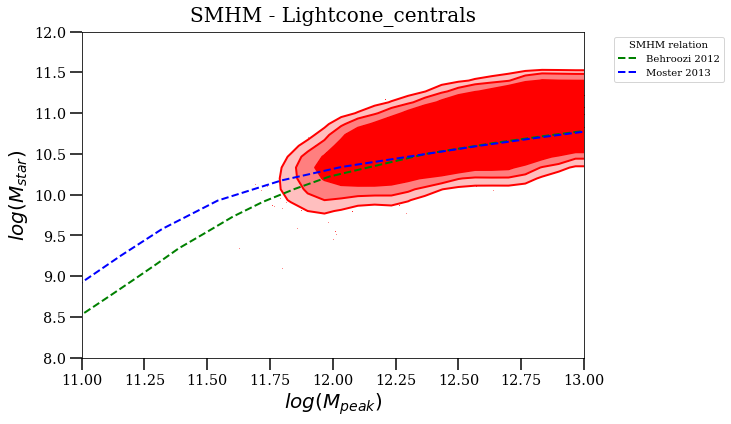

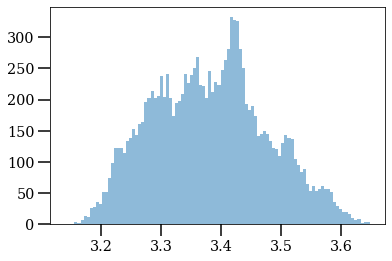

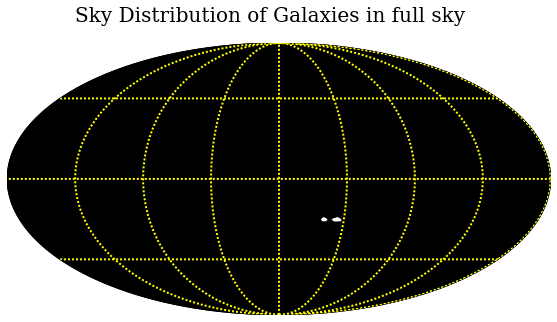

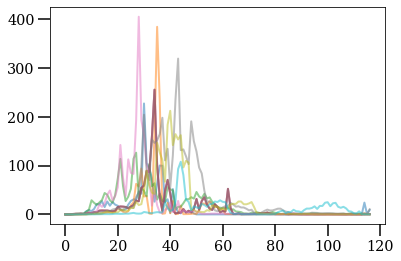

In [ ]:
plt.hist(np.log10(matches_for_lc['peak_mass']), alpha=0.5, bins=100);
plot_utils.plot_SMHM_comparison(matches_for_lc['peak_mass'], matches_for_lc['stellar_mass'], 'Lightcone_centrals')
plt.hist(matches_for_lc['redshift'], alpha=0.5, bins=100);
plot_utils.basemap_plot(matches_for_lc['ra'], matches_for_lc['dec'])
# plt.hist(np.log10(matches_for_lc[0]['stellar_mass']), alpha=0.5, bins=100);
plt.plot(matches_for_lc['sfh'][0:10].T, alpha=0.5);

In [ ]:
# central_cond = (matches_for_lc[0]['central'] == 1)
# satellite_cond = (matches_for_lc[0]['central'] == 0) & ((matches_for_lc[0]['merged'] == 0))
# merged_cond = (matches_for_lc[0]['central'] == 0) & ((matches_for_lc[0]['merged'] == 1))

# print('Central', matches_for_lc[0]['time_infall'][central_cond].shape)
# print('Satellite', matches_for_lc[0]['time_infall'][satellite_cond].shape)
# print('Merged', matches_for_lc[0]['time_infall'][merged_cond].shape)

# plt.hist(matches_for_lc[0]['time_infall'][central_cond])
# plt.hist(matches_for_lc[0]['time_infall'][satellite_cond])
# plt.hist(matches_for_lc[0]['time_infall'][merged_cond])

In [ ]:
# #### HYDRO/UM stuff only

smdpl_cosmo = simulation_models.get_cosmo(config['reference_simulation']['name'])

data_a1 = bpl_analysis.load_bpl_data(config['reference_simulation']['sim_dir'], '1.000000', 'Centrals')
# data_a1 = bpl_analysis.load_bpl_data(config['reference_simulation']['sim_dir'], '0.664300', "Non-centrals")

redshift = np.array([0.5, 0.25, 0.0])
cosmic_time = smdpl_cosmo.age(redshift)
logcosmic_time = np.log10(cosmic_time)

t0 = cosmic_time[-1]
print(f"age of the universe: {t0} Gyrs")

# dirInUM = '/lcrc/project/halotools/UniverseMachine/SMDPL/sfh_binaries_dr1_bestfit/'

time_bpl, scale_bpl = bpl_analysis.bpl_times_scale(config['reference_simulation']['sim_dir'])
time_a1 = np.where(scale_bpl == 1.)
time_arr_a1 = time_bpl[:time_a1[0][0] + 1]

bpl_sfh = data_a1["sfr_history_all_prog"]
bpl_sm = data_a1["sm"]

def initialize_cosmology(config):
    """Initialize cosmology and compute cosmic time and scale."""
    smdpl_cosmo = simulation_models.get_cosmo(config['reference_simulation']['name'])
    redshift = np.array([0.5, 0.25, 0.0])
    cosmic_time = smdpl_cosmo.age(redshift)
    logcosmic_time = np.log10(cosmic_time)
    t0 = cosmic_time[-1]
    print(f"Age of the universe: {t0} Gyrs")
    return smdpl_cosmo, cosmic_time, logcosmic_time, t0

def get_bpl_times_scale(config):
    """Retrieve time and scale for bpl analysis."""
    time_bpl, scale_bpl = bpl_analysis.bpl_times_scale(config['reference_simulation']['sim_dir'])
    return time_bpl, scale_bpl

def prepare_time_array(scale_bpl, time_bpl, target_scale):
    """Prepare time array for a given scale."""
    time_idx = np.where(scale_bpl == target_scale)[0][0]
    return time_bpl[:time_idx + 1]

def load_and_process_data(sim_dir, scale, galaxy_type, smdpl_cosmo, time_arr, V_bpl):
    """Load and process BPL data for a given scale and galaxy type."""
    data = bpl_analysis.load_bpl_data(sim_dir, f'{scale:.6f}', galaxy_type)
    sorted_mpeak = bpl_analysis.peak_mass_smdpl(data)
    infall_time = bpl_analysis.infall_time_smdpl(smdpl_cosmo, data)
    rank_sorted_mpeak = bpl_analysis.mass_rank_smdpl(data, V_bpl)
    t50 = bpl_analysis.mass_time_smdpl(time_arr, data, 0.5)
    t25 = bpl_analysis.mass_time_smdpl(time_arr, data, 0.25)
    return np.array([t50, t25, sorted_mpeak, infall_time]).T

# Main Script
smdpl_cosmo, cosmic_time, logcosmic_time, t0 = initialize_cosmology(config)
time_bpl, scale_bpl = get_bpl_times_scale(config)

# Prepare time arrays for different scales
time_arr_a1 = prepare_time_array(scale_bpl, time_bpl, 1.0)
time_arr_a06 = prepare_time_array(scale_bpl, time_bpl, 0.664300)

# Process centrals
bpl_mass_times_central = load_and_process_data(
    config['reference_simulation']['sim_dir'], 1.0, "Centrals", smdpl_cosmo, time_arr_a1, V_bpl
)

# Process satellites & merged galaxies at z=0
bpl_mass_times_noncentral_a1 = load_and_process_data(
    config['reference_simulation']['sim_dir'], 1.0, "Non-centrals", smdpl_cosmo, time_arr_a1, V_bpl
)

# Process satellites & merged galaxies at z=0.5
bpl_mass_times_noncentral_a06 = load_and_process_data(
    config['reference_simulation']['sim_dir'], 0.664300, "Non-centrals", smdpl_cosmo, time_arr_a06, V_bpl
)

In [ ]:
# ### HACC-BPL cross-matching

# central_cond = (matches_for_lc[0]['central'] == 1)
# satellite_cond = (matches_for_lc[0]['central'] == 0) & ((matches_for_lc[0]['merged'] == 0))
# merged_cond = (matches_for_lc[0]['central'] == 0) & ((matches_for_lc[0]['merged'] == 1))

# match_mass_time = np.array([matches_for_lc[0]['central'], matches_for_lc[0]['merged'], matches_for_lc[0]['t50_a1'], matches_for_lc[0]['t25_a1'], matches_for_lc[0]['peak_mass'], matches_for_lc[0]['time_infall']]).T

# # Step 1: Classify galaxies into central, satellite, and merged
# central_indices = np.where(central_cond)[0]
# satellite_indices = np.where(satellite_cond)[0]
# merged_indices = np.where(merged_cond)[0]

# # Step 2: Prepare match_mass_time arrays for each category
# match_mass_time_central = match_mass_time[central_indices, 2:]
# match_mass_time_satellite = match_mass_time[satellite_indices, 2:]

# # Step 3: Compute a_merged_infall for merged galaxies and split by condition
# a_merged_infall = 1 / (1 + matches_for_lc[0]['redshift'][merged_cond])
# merged_high_a_indices = merged_indices[a_merged_infall > 0.664300]
# merged_low_a_indices = merged_indices[a_merged_infall <= 0.664300]

# match_mass_time_merged_high_a = match_mass_time[merged_high_a_indices, 2:]
# match_mass_time_merged_low_a = match_mass_time[merged_low_a_indices, 2:]

# # Step 4: Call kdtree_match for each category
# match_sfh_central, match_sm_central = kdtree_match(bpl_mass_times_central, match_mass_time_central)
# match_sfh_satellite, match_sm_satellite = kdtree_match(bpl_mass_times_noncentral_a1, match_mass_time_satellite)

# match_sfh_merged_high_a, match_sm_merged_high_a = kdtree_match(bpl_mass_times_noncentral_a1, match_mass_time_merged_high_a)
# match_sfh_merged_low_a, match_sm_merged_low_a = kdtree_match(bpl_mass_times_noncentral_a06, match_mass_time_merged_low_a)

# # Step 5: Initialize full arrays for sfh and stellar_mass
# num_galaxies = len(match_mass_time)
# sfh_full = np.zeros((num_galaxies, 117))
# stellar_mass_full = np.zeros(num_galaxies)

# # Step 6: Assign matched values back to the full arrays
# sfh_full[central_indices] = match_sfh_central
# stellar_mass_full[central_indices] = match_sm_central

# sfh_full[satellite_indices] = match_sfh_satellite
# stellar_mass_full[satellite_indices] = match_sm_satellite

# sfh_full[merged_high_a_indices] = match_sfh_merged_high_a
# stellar_mass_full[merged_high_a_indices] = match_sm_merged_high_a

# sfh_full[merged_low_a_indices] = match_sfh_merged_low_a
# stellar_mass_full[merged_low_a_indices] = match_sm_merged_low_a

# # Step 7: Update matches_for_lc
# matches_for_lc[0]['sfh'] = sfh_full
# matches_for_lc[0]['stellar_mass'] = stellar_mass_full

# # Step 8: Print summary
# print(f"Assigned SFH and stellar mass:")
# print(f"  Centrals: {len(central_indices)}")
# print(f"  Satellites: {len(satellite_indices)}")
# print(f"  Merged (high a_merged_infall): {len(merged_high_a_indices)}")
# print(f"  Merged (low a_merged_infall): {len(merged_low_a_indices)}")



In [ ]:
plot_utils.plot_SMHM_comparison(data_a1['mpeak'][data_a1['upid'] == -1], data_a1['sm'][data_a1['upid'] == -1], 'BPL_centrals')
plot_utils.plot_SMHM_comparison(matches_for_lc['peak_mass'], matches_for_lc['stellar_mass'], 'Lightcone_centrals')

In [ ]:
# closest_num = 1
# bpl_tree = scipy.spatial.KDTree(bpl_mah_norm)
# bpl_tree = scipy.spatial.KDTree(bpl_mass_times_satellite)

# distance_satellite, alphaq_index_satellite = bpl_tree.query(match_mass_time_satellite, k=closest_num)

# bpl_index = kdtree_match(bpl_mass_times_central, match_mass_time)


In [ ]:
plot_utils.plot_summary_histograms(time_infall, match_state, "Time infall")
plot_utils.plot_summary_histograms(t50_a1, match_state, 't50')
plot_utils.plot_summary_histograms(t25_a1, match_state, 't25')
plot_utils.plot_summary_histograms(peak_mass, match_state, "Peak mass")
plot_utils.plot_summary_histograms(rank_peak_mass, match_state, "Rank Peak core mass")

In [ ]:
plot_utils.plot_accretion_histories(alphaq_analysis_age, fof_halo_mass, core_status, "Central")
plot_utils.plot_accretion_histories(alphaq_analysis_age, fof_halo_mass, core_status, "Satellite")
plot_utils.plot_accretion_histories(alphaq_analysis_age, fof_halo_mass, core_status, "Merged")
plot_utils.plot_core_status(core_status)



#############################

time_infall = cores_analysis.infall_time_alphaq(core_status, alphaq_analysis_age)
t50_a1 = cores_analysis.mass_time_alphaq(fof_halo_mass, alphaq_analysis_age, 0.5)
t25_a1 = cores_analysis.mass_time_alphaq(fof_halo_mass, alphaq_analysis_age, 0.25)
peak_mass = cores_analysis.peak_mass_HACC(fof_halo_mass)
rank_peak_mass = cores_analysis.mass_rank_alphaq(fof_halo_mass, V_alphaq)

#############################

# plot_utils.plot_summary_histograms(time_infall, core_status, "Time infall")
# plot_utils.plot_summary_histograms(t50_a1, core_status, 't50')
# plot_utils.plot_summary_histograms(t25_a1, core_status, 't25')
# plot_utils.plot_summary_histograms(peak_mass, core_status, "Peak mass")
# plot_utils.plot_summary_histograms(rank_peak_mass, core_status, "Rank Peak core mass")